# Create and train a CNN

![cnn](https://i.imgflip.com/2n3h1m.jpg)

In [1]:
%%capture install_pandas

!pip install pandas
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os

In [3]:
DATA_DIRECTORY_DOGS = "./data/dogs/"
DATA_DIRECTORY_CATS = "./data/cats/"

SAMPLE_SIZE = 2000

DOGS = [ filename for filename in os.listdir(DATA_DIRECTORY_DOGS) if "jpg" in filename]
CATS = [ filename for filename in os.listdir(DATA_DIRECTORY_CATS) if "jpg" in filename]

CATS_SAMPLE = np.random.choice( CATS, size=int(SAMPLE_SIZE/2), replace=False)
DOGS_SAMPLE = np.random.choice( DOGS, size=int(SAMPLE_SIZE/2), replace=False)

CATS_SAMPLE_FULLPATH = [DATA_DIRECTORY_CATS + file for file in CATS_SAMPLE]
DOGS_SAMPLE_FULLPATH = [DATA_DIRECTORY_DOGS + file for file in DOGS_SAMPLE]

ANIMALS = CATS_SAMPLE_FULLPATH + DOGS_SAMPLE_FULLPATH
np.random.shuffle(ANIMALS)

In [4]:
from tqdm import tnrange
from tqdm.notebook import tqdm
from keras.preprocessing import image

images = []
labels = []

IMG_WIDTH_AND_HEIGHT = 96

for animal_path in tqdm(ANIMALS,desc="Loading Images",unit="images"):
    img = image.load_img(animal_path, grayscale=False, color_mode="rgb", target_size=(IMG_WIDTH_AND_HEIGHT,IMG_WIDTH_AND_HEIGHT) )
    img_label = np.array([1,0])
    if "dog" in animal_path:
        img_label = np.array([0,1])
    try:
        images.append( image.img_to_array(img) ) 
        labels.append(img_label)
    except:
        pass

Loading Images:   0%|          | 0/2000 [00:00<?, ?images/s]

In [5]:
images_data=np.array(images)
class_labels=np.array(labels)

print(images_data.shape)

(2000, 96, 96, 3)


In [6]:
import numpy as np

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

In [7]:
mobilenetv2_without_top = MobileNetV2(weights='imagenet', input_shape=(96,96,3), include_top=False, pooling="max")
mobilenetv2_with_top = MobileNetV2(weights='imagenet', input_shape=(96,96,3), include_top=True)

14548992/14536120 [==============================] - 2s 0us/step


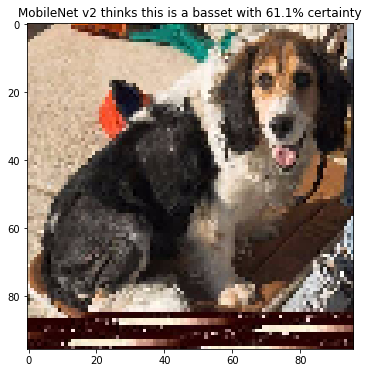

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

random_index = np.random.choice( len(class_labels), size=1 )
random_image = images_data[random_index, :][0]

np_random_image = preprocess_input(random_image.copy())
output_mobile_of_random_animal = mobilenetv2_with_top.predict(np.expand_dims(np_random_image, axis=0))

predictions = decode_predictions(output_mobile_of_random_animal)


plt.figure(figsize=(6,6))
plt.imshow(random_image/255)
plt.title( "MobileNet v2 thinks this is a {} with {:.1f}% certainty" .format(predictions[0][0][1],predictions[0][0][2]*100 ) ) 
plt.show()

In [12]:
preprocessed_images = preprocess_input(images_data.copy())

In [13]:
preprocessed_images.shape

(2000, 96, 96, 3)

In [14]:
raw_mobilenet_signals = mobilenetv2_without_top.predict(preprocessed_images) 

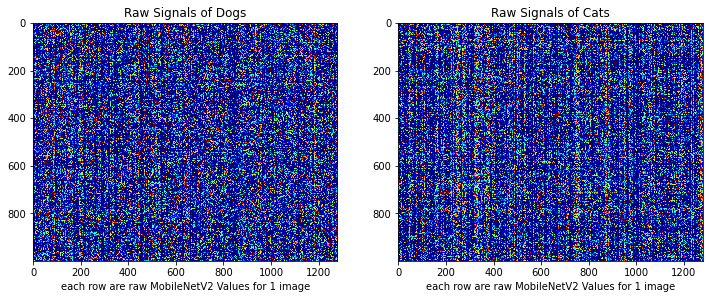

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(raw_mobilenet_signals[class_labels[:,1]==1], cmap='jet', interpolation='nearest')
plt.title("Raw Signals of Dogs")
plt.xlabel("each row are raw MobileNetV2 Values for 1 image")

plt.subplot(122)
plt.imshow(raw_mobilenet_signals[class_labels[:,1]==0], cmap='jet', interpolation='nearest')
plt.title("Raw Signals of Cats")
plt.xlabel("each row are raw MobileNetV2 Values for 1 image")
plt.show()

In [16]:
import numpy as np

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

In [17]:
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout,BatchNormalization,Activation

In [18]:
model=Sequential()
model.add(Dense(50,activation="relu",input_shape=(1280,)))
model.add(Dense(25,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                64050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 52        
Total params: 65,377
Trainable params: 65,377
Non-trainable params: 0
_________________________________________________________________


In [19]:
loss_graph = model.fit(raw_mobilenet_signals,class_labels,validation_split=0.25,epochs=5,batch_size=150)

Epoch 1/5
10/10 [==============================] - 0s 17ms/step - loss: 0.3520 - accuracy: 0.8620 - val_loss: 0.1976 - val_accuracy: 0.9280
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9720 - val_loss: 0.2122 - val_accuracy: 0.9340
Epoch 3/5
10/10 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9873 - val_loss: 0.1846 - val_accuracy: 0.9320
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 0.0192 - accuracy: 0.9973 - val_loss: 0.1801 - val_accuracy: 0.9460
Epoch 5/5
10/10 [==============================] - 0s 4ms/step - loss: 0.0129 - accuracy: 0.9987 - val_loss: 0.1952 - val_accuracy: 0.9440


<AxesSubplot:>

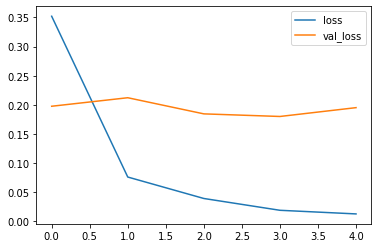

In [20]:
pd.DataFrame( loss_graph.history )[['loss', 'val_loss']].plot()

<AxesSubplot:>

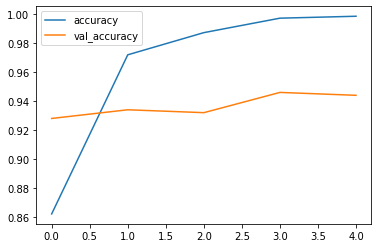

In [21]:
pd.DataFrame( loss_graph.history )[['accuracy', 'val_accuracy']].plot()